In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [2]:
base_dir = Path().resolve()
sys.path.append(str(base_dir / '../'))

from utils.preprocess import *
from utils.model import *
from utils.train import *
from utils.eval import *

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.


In [3]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    debug: bool = False
    device: str = 'cuda:2'
    # Data config
    n_splits: int = 5
    seed: int = 111
    imgconf_file: str = '../../data/VinBigData/train.csv'
    meta_file: str = '../../data/VinBigData/train_meta.csv'
    imgdir_name: str = "../../data/VinBigData/png1024"
    img_size: int = 1024
    result_id: int = 0
    batch_size: int = 8
    valid_aug_kwargs: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {})
        
    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self

In [4]:
config_dict = {
    'debug': False,
    'batch_size': 25,
    "valid_aug_kwargs": {
        "Normalize": {"mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225)}
    },
}
config = Config().update(config_dict)

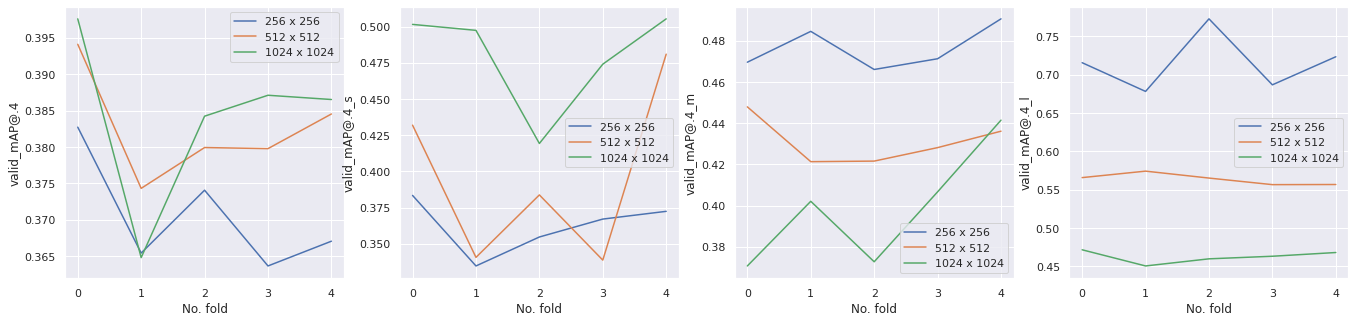

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(23, 5))

for met, ax in zip(['valid_mAP@.4', 'valid_mAP@.4_s', 'valid_mAP@.4_m', 'valid_mAP@.4_l'], axes):
    for i, img_size in enumerate([256, 512, 1024]):
        mAP = list()
        for fold in range(Config.n_splits):
            history = pd.read_csv(base_dir / f'results0{i}/fold-{fold + 1}' / 'history.csv', index_col=0)
            mAP += [np.max(history[met])]
        ax.plot(mAP, label=f'{img_size} x {img_size}')
    ax.set_ylabel(met)
    ax.set_xlabel('No. fold')
    ax.legend()
plt.show()

In [5]:
classes_nms = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis",
    "No Finding"
]
classes_dict = {index + 1: class_name  for index, class_name in enumerate(classes_nms)}

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
def load_train_data(filepath: str, meta_filepath: str, img_size: int) -> pd.DataFrame:
    train = pd.read_csv(filepath)
    train.fillna(0, inplace=True)
    train.loc[train["class_id"] == 14, ['x_max', 'y_max']] = 1.0
    
    train_meta = pd.read_csv(meta_filepath)
    
    train = pd.merge(train, train_meta, how='left', on='image_id')
    
    train[f'x_min_{img_size}'] = (img_size / train['dim1'] * train['x_min']).astype(int)
    train[f'x_max_{img_size}'] = (img_size / train['dim1'] * train['x_max']).astype(int)
    train[f'y_min_{img_size}'] = (img_size / train['dim0'] * train['y_min']).astype(int)
    train[f'y_max_{img_size}'] = (img_size / train['dim0'] * train['y_max']).astype(int)
    
    return train

In [42]:
train = load_train_data(filepath=str(base_dir / config.imgconf_file), meta_filepath=str(base_dir / config.meta_file), img_size=config.img_size)
mkf = MultilabelKFoldWrapper(train, config.n_splits, config.seed, remove_normal=False)
dataset_dicts = get_vinbigdata_dicts(
    imgdir=base_dir / config.imgdir_name, 
    train_df=train,
    meta_filepath=base_dir / config.meta_file,
    train_data_type=f'png{config.img_size}',
    debug=config.debug,
)

Load from cache dataset_dicts_cache_png1024_debug0.pkl


In [43]:
# add annotation into normal images
for dd in dataset_dicts:
    if len(dd['annotations']) == 0:
        dd['annotations'] = [{
            'bbox': [0, 0, config.img_size, config.img_size],
            'bbox_mode': None,
            'category_id': 14
        }]

In [44]:
cols = ['x_min', 'y_min', 'x_max', 'y_max']
train_ = train.drop(columns=['x_min', 'y_min', 'x_max', 'y_max']).rename(columns={f'{c}_{config.img_size}': c for c in cols})
train_['class_id'] += 1

In [45]:
train_.loc[train_['class_id'] == 15, 'x_max'] = config.img_size
train_.loc[train_['class_id'] == 15, 'y_max'] = config.img_size

In [46]:
class FasterRCNNVinBigDataset(VinBigDataset):
    def __init__(self, dataset_dicts: Dict[str, Any], transform: Transform, train: bool = True):
        super().__init__(dataset_dicts=dataset_dicts, transform=transform, train=train)
        
        for i in range(len(self.dataset_dicts)):
            n_annot = len(self.dataset_dicts[i]['annotations'])
            for j in range(n_annot):
                self.dataset_dicts[i]['annotations'][j]['category_id'] += 1 # background (id = 0)

In [47]:
fold = 0

_, valid_df = mkf[0]

valid_idx = list(pd.DataFrame({'image_id': [dd['image_id'] for dd in dataset_dicts]}).query(f"image_id in {valid_df['image_id'].values.tolist()}").index)

valid_dataset = FasterRCNNVinBigDataset(dataset_dicts=[dataset_dicts[i] for i in valid_idx], transform=Transform(config.valid_aug_kwargs, train=True))

valid_loader = DataLoader(
    valid_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)
valid_evaluator = VinBigDataEval(train_.query(f'image_id in {valid_dataset.image_ids}'))

Generating image data...
Generating category data...
Generating annotation data...


In [48]:
def make_prediction(fold: int, result_id: int, device: str):
    device = torch.device(device)

    detector = ObjectDetector(model=load_faster_rcnn(num_classes=16), train_evaluator=None, valid_evaluator=None, outdir=base_dir)
    detector.load_state_dict(torch.load(str(base_dir / f'results0{result_id}/fold-{fold + 1}' / 'model_best.pt'), map_location=device))
    detector.to(device)
    detector.eval()

    preds_list = list()
    for batch in tqdm(valid_loader):
        images, targets, image_ids = batch
        images = list(image.to(device) for image in images)
        preds = detector(images)

        del images
        gc.collect()

        for i in range(len(preds)):
            preds[i] = {k: preds[i][k].detach().cpu().numpy() for k in preds[i].keys()}
            preds[i]['image_id'] = image_ids[i]
        preds_list += preds
        
    records = {'image_id': list(), 'PredictionString': list()}

    for preds in preds_list:
        boxes, labels, scores = preds['boxes'], preds['labels'], preds['scores']
        obj_str = list()
        for box, label, score in zip(boxes, labels, scores):
            obj_str += [str(label)] + [str(score)] + box.astype(str).tolist()

        records['image_id'] += [preds['image_id']]
        records['PredictionString'] += [' '.join(obj_str)]

    return pd.DataFrame(records)

In [49]:
def evaluate_mAP(pred_df: pd.DataFrame):
    mAPs = dict()
    for cls_id, cls_nm in tqdm(classes_dict.items()):
        results = valid_evaluator.evaluate(valid_pred_df, category_ids=[cls_id])
        mAPs[cls_nm] = results.stats[0]

    results = valid_evaluator.evaluate(valid_pred_df)
    mAPs['all'] = results.stats[0]
    
    return mAPs

In [50]:
# valid_pred_df = make_prediction(fold=fold, result_id=config.result_id, device=config.device)
mAPs = evaluate_mAP(valid_pred_df)

  0%|          | 0/15 [00:00<?, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.07s).
Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.488
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.703
Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.541
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.426
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.867
Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.867
Average Recall     (AR) @[ IoU=0.40:0.40 | area= small | ma

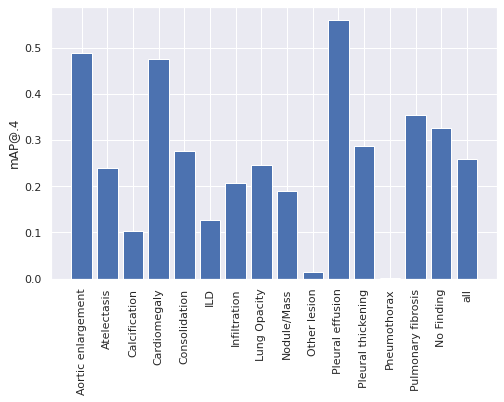

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.bar(mAPs.keys(), mAPs.values())
ax.set_ylabel('mAP@.4')
plt.xticks(rotation=90)
plt.savefig(str(base_dir / f'results0{config.result_id}/fold-{fold + 1}' / f'mAP{config.img_size}'))

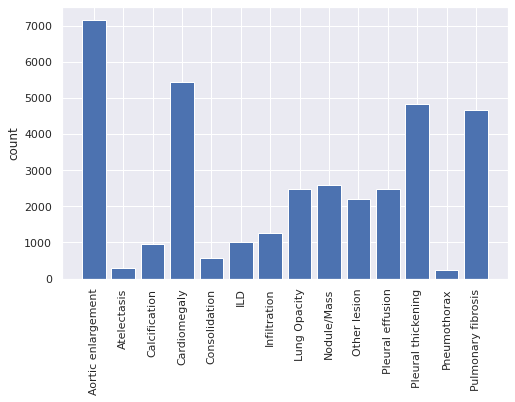

In [58]:
size = train_.groupby('class_id').size()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.bar(classes_nms[:-1], size.values[:-1])
ax.set_ylabel('count')
plt.xticks(rotation=90)
plt.show()

In [41]:
train_[train_['image_id'] == '2a083ae0533547d99e2de9b96fbd50a4']

,image_id,class_name,class_id,rad_id,dim0,dim1,x_min,x_max,y_min,y_max,id
9143,2a083ae0533547d99e2de9b96fbd50a4,No finding,15,R8,2430,1994,0,1994.0,0,2430.0,9143
32167,2a083ae0533547d99e2de9b96fbd50a4,No finding,15,R6,2430,1994,0,1994.0,0,2430.0,32167
46113,2a083ae0533547d99e2de9b96fbd50a4,No finding,15,R2,2430,1994,0,1994.0,0,2430.0,46113


In [17]:
valid_pred_df

,image_id,PredictionString
0,ba1795ee5daae1ed415756c3f4f21b48,3 0.98371994 85.086914 107.150986 190.15259 13...
1,051c2436c0acdb5e09d085c7e4a764f3,3 0.9911686 98.56654 147.86313 210.08919 177.8...
2,e6e1f33532a2f3f93d17d2be963cd122,0 0.88286257 135.20189 62.787056 161.63078 87....
3,9b1d076abcb937c2e19f7c2e10dbcbc0,0 0.867934 129.77022 47.26985 166.13412 87.027...
4,8f98e3e6e86e573a6bd32403086b3707,3 0.90772855 94.47789 134.23656 199.96017 172....
...,...,...
877,495fcdab0b3ae4e0856700741d4ff17b,0 0.9823015 124.95781 77.048355 159.80551 113....
878,c3adefe651baf211a73e391f3068e916,0 0.96631 128.41762 64.178734 152.1932 87.2689...
879,02562eb68a9c682f5f644fa7a099733f,13 0.87485504 52.157166 60.72292 99.5284 97.53...
880,299057220a9508923d271ac70bff843b,0 0.9772025 124.929146 75.94047 154.95493 109....


In [30]:
valid_pred_df[valid_pred_df['PredictionString'].agg(lambda x: ' 0 ' in x)]

,image_id,PredictionString


In [31]:
train_df, _ = mkf[0]

In [36]:
train_idx = list(pd.DataFrame({'image_id': [dd['image_id'] for dd in dataset_dicts]}).query(f"image_id in {train_df['image_id'].values.tolist()}").index)

train_dataset = VinBigDataset(dataset_dicts=[dataset_dicts[i] for i in train_idx], transform=Transform(config.valid_aug_kwargs, train=True))

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)
train_evaluator = VinBigDataEval(train_.query(f'image_id in {train_dataset.image_ids}'))

Generating image data...
Generating category data...
Generating annotation data...


In [39]:
device = torch.device(config.device)

detector = ObjectDetector(model=load_faster_rcnn(), train_evaluator=None, valid_evaluator=None, outdir=base_dir)
detector.load_state_dict(torch.load(str(base_dir / f'results0{config.result_id}/fold-{fold + 1}' / 'model_best.pt')))
detector.to(device)
detector.eval()

preds_list = list()
for batch in tqdm(train_loader):
    images, targets, image_ids = batch
    images = list(image.to(device) for image in images)
    preds = detector(images)

    del images
    gc.collect()

    for i in range(len(preds)):
        preds[i] = {k: preds[i][k].detach().cpu().numpy() for k in preds[i].keys()}
        preds[i]['image_id'] = image_ids[i]
    preds_list += preds

  0%|          | 0/141 [00:00<?, ?it/s]